# How do holidays affect EMS call volume?


This analysis includes all locally available EMS calls from the following departments:

    -Bellevue Fire Department (74731)
    -Richmond Fire and Emergency Services (93345)
    -City of Fairfax Fire Department (81154)
    -Washington DC Fire & EMS Department (98606)

## First we need to import libraries and aggregate the NFORS data

In [1]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from elasticsearch_dsl.query import MultiMatch, Match
from elasticsearch_dsl import Q
from tqdm import tqdm_notebook
import json
from dateutil.relativedelta import SU
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import AbstractHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import Holiday
import matplotlib.pyplot as plt
from copy import deepcopy
import datetime

raw_df = pd.read_json('query_results.json')


#Converting date
raw_df['date'] = raw_df['description.event_opened'].apply(lambda x: x[:10])
#Aggregation function
def myagg(x):
    
    #First need to group
    d = {
        'ems_calls': np.sum(x['NFPA.type']=='EMS'),
        'snow': 'snow' in x['weather.daily.precipType'].values,
        'rain': 'rain' in x['weather.daily.precipType'].values,
        'high_temp': np.mean(x['weather.daily.temperatureHigh'])
        }
    
    return pd.Series(d,index=d.keys())

#Day aggregation
df = raw_df.groupby(['fire_department.firecares_id','date']).apply(myagg).reset_index()

#Adding day of week
df = df.merge(raw_df[['date','description.day_of_week']].drop_duplicates(), on='date')
#Renaming the day of week column to make it shorter
df = df.rename(columns={'description.day_of_week':'day'})
df['month'] = df.apply(lambda x: x['date'][5:7], axis=1)
#No longer need the date since we have all the information we need (day of week and month)
# df = df.drop('date',axis=1)
df = df[df['ems_calls'] > 0].reset_index(drop=True)

#Converting df dates to datetime objects
df['date'] = df.apply(lambda x: datetime.datetime.strptime(x['date'],'%Y-%m-%d'),axis=1)

#group by department to find mean
means = df[['fire_department.firecares_id','ems_calls']].groupby('fire_department.firecares_id').aggregate(np.mean).reset_index()
means = means.rename(columns = {'ems_calls': 'mean_calls'})
df = df.merge(means,on='fire_department.firecares_id')
df['norm_calls'] = df['ems_calls']/df['mean_calls']

## Using the holidays library to determine if a date is a holiday

In [4]:
#We can create new rules with this class inheritance
class custom_calendar(AbstractHolidayCalendar):
    new_rules = [
        Holiday('Halloween', month=10,day=31),
        Holiday('Christmas Eve', month=12,day=24),
        Holiday('New Years Eve', month=12,day=31),
        Holiday('DST time change', month=3, day=1, offset=pd.DateOffset(weekday=SU(2)))
        
        
    ]
    
    rules = calendar().rules + new_rules

cal = custom_calendar()
start = np.min(df['date'])
end = np.max(df['date'])
holidays = cal.holidays(start=start,end=end,return_name=True).reset_index()
holidays = holidays.rename(columns={'index':'date', 0:'holiday'})

#But really we want the Monday after the time change
holidays['date'] = holidays.apply(lambda x: x['date'] + datetime.timedelta(days=1) 
               if x['holiday'] == 'DST time change' else x['date'], axis=1)


df = df.merge(holidays, on='date', how='left').fillna('N/A')

##  Here are the holidays in the database:

In [6]:
print(np.unique(df['holiday']))

['Christmas' 'Christmas Eve' 'Columbus Day' 'DST time change'
 'Dr. Martin Luther King Jr.' 'Halloween' 'July 4th' 'Labor Day'
 'MemorialDay' 'N/A' 'New Years Day' 'New Years Eve' 'Presidents Day'
 'Thanksgiving' 'Veterans Day']


## Aggregated comparison of all holidays

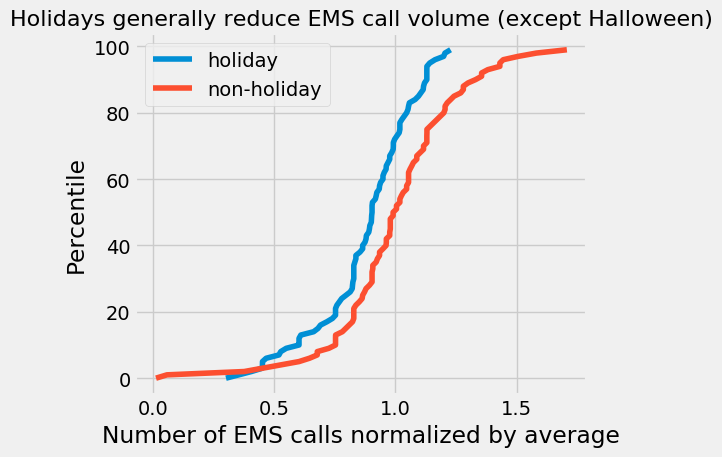

In [8]:
# start with pooling all holidays together
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('fivethirtyeight')



#Exclude halloween
holiday = np.array(df[(df['holiday'] != 'N/A') & (df['holiday'] != 'Halloween')        ]['norm_calls'])
nholiday = np.array(df[(df['holiday'] == 'N/A') | (df['holiday'] == 'Halloween')]['norm_calls'])
percentile = np.arange(0,100)


fig,ax = plt.subplots()
ax.plot(np.percentile(holiday,percentile),percentile)
ax.plot(np.percentile(nholiday,percentile),percentile)
ax.legend(['holiday', 'non-holiday'])
ax.set_xlabel('Number of EMS calls normalized by average')
ax.set_ylabel('Percentile')
ax.set_title('Holidays generally reduce EMS call volume (except Halloween)',fontsize=16)
fig.tight_layout()
plt.show()
fig.savefig('holiday_effect')


## What about each holiday separately?
Keep in mind, small sample sizes are an issue here

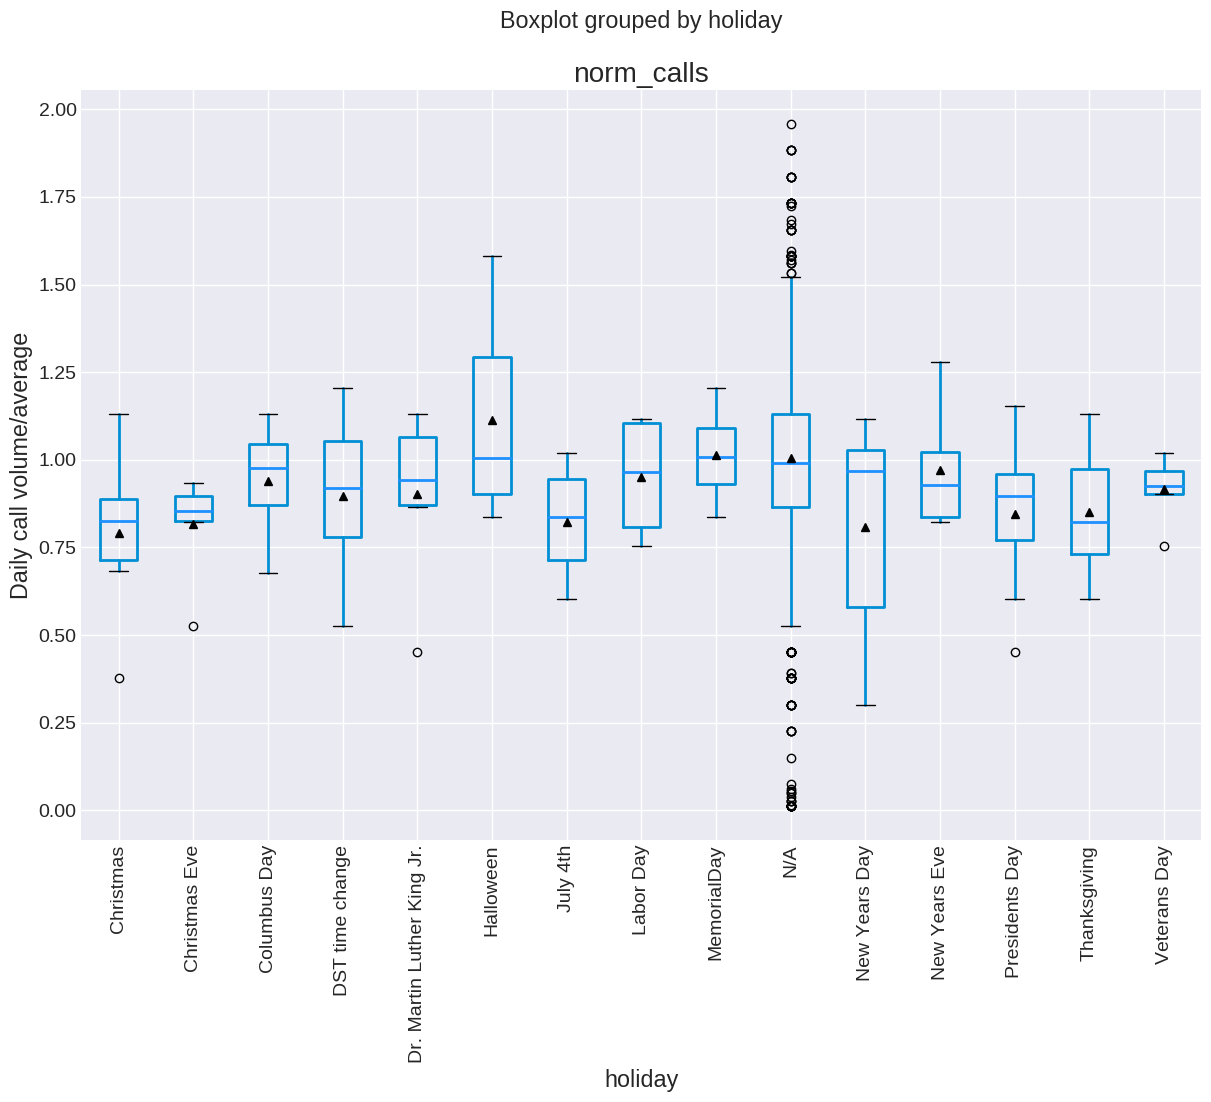

In [9]:
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = [14,10]

boxprops = dict(linestyle='-',color='k')
medianprops = dict(linestyle='-',color='r')


bp = df.boxplot(column='norm_calls',by='holiday',showmeans=True,return_type='dict',rot=90)
#Changing the style for the medians
[item.set_color('dodgerblue') for item in bp['norm_calls']['medians']]
[item.set_linewidth(2) for item in bp['norm_calls']['medians']]
[item.set_linewidth(2) for item in bp['norm_calls']['boxes']]
[item.set_linewidth(2) for item in bp['norm_calls']['whiskers']]
[item.set_markerfacecolor('k') for item in bp['norm_calls']['means']]
[item.set_markeredgecolor('k') for item in bp['norm_calls']['means']]
plt.ylabel('Daily call volume/average')
plt.savefig('boxplot_by_holiday')

plt.show()

## What about the day before and the day after a holiday?
I'm just going to use actual federal holidays here, not the ones I added

In [48]:
businessdays = CustomBusinessDay(calendar=calendar())
cal = calendar()
fed_holidays = cal.holidays(start=start,end=end,return_name=True).reset_index()
fed_holidays = fed_holidays.rename(columns = {'index':'date', 0:'holiday'})
fed_holidays['type'] = 'holiday'

#Getting business days before and after federal holidays
bday_after = pd.DataFrame([i + businessdays for i in fed_holidays['date']], columns=['date'])
bday_after['type'] = 'bday_after'
bday_before = pd.DataFrame([i - businessdays for i in fed_holidays['date']] , columns=['date'])
bday_before['type'] = 'bday_before'

#Merging into one dataframe
bday_df = bday_before.merge(bday_after,how='outer')
bday_df = bday_df.merge(fed_holidays[['date','type']],how='outer')

df = df.merge(bday_df,how='left').fillna('N/A')














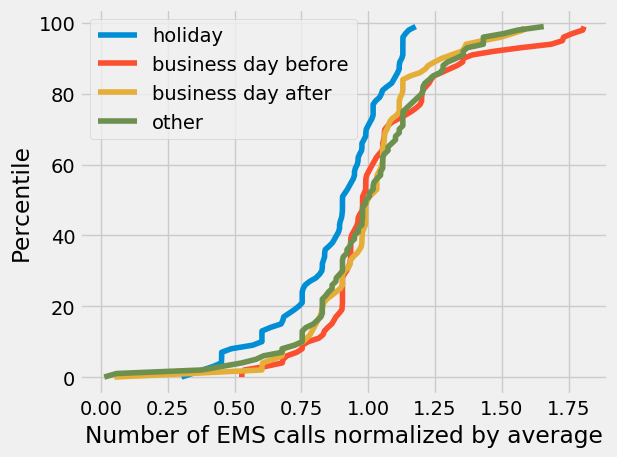

In [61]:
# start with pooling all holidays together
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('fivethirtyeight')



#Exclude halloween
holiday = np.array(df[df['type']=='holiday']['norm_calls'])
before = np.array(df[df['type']=='bday_before']['norm_calls'])
after = np.array(df[df['type']=='bday_after']['norm_calls'])
other = np.array(df[df['type']=='N/A']['norm_calls'])
percentile = np.arange(0,100)


fig,ax = plt.subplots()
ax.plot(np.percentile(holiday,percentile),percentile)
ax.plot(np.percentile(before,percentile),percentile)
ax.plot(np.percentile(after,percentile),percentile)
ax.plot(np.percentile(other,percentile),percentile)



ax.legend(['holiday', 'business day before', 'business day after', 'other'])
ax.set_xlabel('Number of EMS calls normalized by average')
ax.set_ylabel('Percentile')
fig.tight_layout()
plt.show()
fig.savefig('businessday_effect')

In [57]:
sliced = df[df['type'] == 'bday_before']

In [59]:
sliced.sort_values(by='norm_calls',ascending=False)

,fire_department.firecares_id,date,ems_calls,snow,rain,high_temp,day,month,mean_calls,norm_calls,holiday,type
643,81154,2018-02-16,24,False,True,61.0557,Friday,02,13.281124,1.807076,N/A,bday_before
280,81154,2017-02-17,24,False,False,51.917,Friday,02,13.281124,1.807076,N/A,bday_before
839,81154,2018-08-31,23,False,True,84.9761,Friday,08,13.281124,1.731781,N/A,bday_before
1742,98606,2018-02-16,136,False,False,N/A,Friday,02,78.921348,1.723235,N/A,bday_before
608,81154,2018-01-12,20,False,True,67.7303,Friday,01,13.281124,1.505897,N/A,bday_before
162,81154,2018-11-09,18,False,True,48.5823,Friday,11,13.281124,1.355307,N/A,bday_before
1527,93345,2018-07-03,97,False,True,94.8973,Tuesday,07,71.690673,1.353035,N/A,bday_before
1655,93345,2016-11-23,93,False,True,54.7179,Wednesday,11,71.690673,1.297240,N/A,bday_before
1586,93345,2018-08-31,89,False,True,87.0596,Friday,08,71.690673,1.241445,N/A,bday_before
979,93345,2019-01-18,88,False,True,51.0815,Friday,01,71.690673,1.227496,N/A,bday_before


In [62]:
df.sort_values(by='norm_calls',ascending=False)

,fire_department.firecares_id,date,ems_calls,snow,rain,high_temp,day,month,mean_calls,norm_calls,holiday,type
297,81154,2017-03-06,26,False,False,52.8738,Monday,03,13.281124,1.957666,N/A,N/A
632,81154,2018-02-05,25,True,False,34.4993,Monday,02,13.281124,1.882371,N/A,N/A
866,81154,2018-09-28,25,False,True,72.9203,Friday,09,13.281124,1.882371,N/A,N/A
748,81154,2018-06-01,25,False,True,86.6878,Friday,06,13.281124,1.882371,N/A,N/A
173,81154,2018-11-20,25,False,True,50.4297,Tuesday,11,13.281124,1.882371,N/A,N/A
200,81154,2018-12-17,24,False,True,52.9967,Monday,12,13.281124,1.807076,N/A,N/A
576,81154,2017-12-11,24,False,True,47.173,Monday,12,13.281124,1.807076,N/A,N/A
643,81154,2018-02-16,24,False,True,61.0557,Friday,02,13.281124,1.807076,N/A,bday_before
688,81154,2018-04-02,24,False,True,47.8275,Monday,04,13.281124,1.807076,N/A,N/A
280,81154,2017-02-17,24,False,False,51.917,Friday,02,13.281124,1.807076,N/A,bday_before
